In [1]:
import os
import sys
from itertools import product
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from src.models.train_model import BTCForecasting

import pickle

sys.dont_write_bytecode = True
from src.utils.utils import *
from src.utils.constants import *
from src.visualization.visualize import *

In [2]:
merged_data = {
    (exchange, data_type): pd.read_parquet(
        os.path.join(INTERIM_DATA_PATH, f'{exchange}_{data_type}_merged.parquet')
    )
    for exchange, data_type in product(EXCHANGES, DATA_TYPES)
}
merged_data[(ALL, UNIFIED)] = pd.read_parquet(os.path.join(INTERIM_DATA_PATH, f'{ALL}_{UNIFIED}_merged.parquet'))

In [3]:
# Training params

view_params = {
    'candles': {
        'use_smoteenn': False,
        'use_rfe': False,
        'criteria': ['gini', 'entropy'],
        'max_depth_range': range(3, 10),
        'min_samples_leaf_range': range(1, 5),
        'min_samples_split_range': range(2, 10),
        'max_leaf_nodes': [10, 20, 50],
        'factor': 3,
        'aggresive_elimination': False,
        'n_splits': 10,
    },
    'orderbook': {
        'use_smoteenn': False,
        'use_rfe': False,
        'criteria': ['gini', 'entropy'],
        'max_depth_range': range(3, 10),
        'min_samples_leaf_range': range(1, 5),
        'min_samples_split_range': range(2, 10),
        'max_leaf_nodes': [10, 20, 50],
        'factor': 3,
        'aggresive_elimination': False,
        'n_splits': 10,
    },
    'unified': {
        'use_smoteenn': False,
        'use_rfe': False,
        'criteria': ['gini', 'entropy'],
        'max_depth_range': range(3, 10),
        'min_samples_leaf_range': range(1, 5),
        'min_samples_split_range': range(2, 10),
        'max_leaf_nodes': [10, 20, 50],
        'factor': 3,
        'aggresive_elimination': False,
        'n_splits': 10,
    }
}

In [4]:
# Training

btcfs = {}

for (exchange, data_type), df in merged_data.items():

    for key, value in view_params[data_type].items():
        exec(f"{key} = {value}")
    
    print(f"\nBest RFC model for {exchange} - {data_type}")

    classifier = RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced_subsample')

    btcf = BTCForecasting(n_splits=n_splits, smoteenn=use_smoteenn, rfe=use_rfe)
    btcf.set_data(df)

    model_params = {
        'classifier__criterion': criteria,
        'classifier__max_depth': max_depth_range,
        'classifier__min_samples_leaf': min_samples_leaf_range,   
        'classifier__min_samples_split': min_samples_split_range,
        'classifier__max_leaf_nodes': max_leaf_nodes
    }
    btcf.train_model(classifier, model_params, factor=factor, aggressive_elimination=aggresive_elimination)
    btcfs[(exchange, data_type)] = btcf

    # Save the best model and results
    model_path = os.path.join(MODELS_DATA_PATH, f"{exchange}_{data_type}_rfc_model.pkl")

    with open(model_path, "wb") as f:
        pickle.dump(btcf, open(model_path, "wb"))

del(merged_data)

Best RFC model for BINANCE - candles
n_iterations: 7
n_required_iterations: 7
n_possible_iterations: 7
min_resources_: 573
max_resources_: 418344
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 1344
n_resources: 573
Fitting 10 folds for each of 1344 candidates, totalling 13440 fits
----------
iter: 1
n_candidates: 448
n_resources: 1719
Fitting 10 folds for each of 448 candidates, totalling 4480 fits
----------
iter: 2
n_candidates: 150
n_resources: 5157
Fitting 10 folds for each of 150 candidates, totalling 1500 fits
----------
iter: 3
n_candidates: 50
n_resources: 15471
Fitting 10 folds for each of 50 candidates, totalling 500 fits
----------
iter: 4
n_candidates: 17
n_resources: 46413
Fitting 10 folds for each of 17 candidates, totalling 170 fits
----------
iter: 5
n_candidates: 6
n_resources: 139239
Fitting 10 folds for each of 6 candidates, totalling 60 fits
----------
iter: 6
n_candidates: 2
n_resources: 417717
Fitting 10 folds for each of 2 candidates, to

In [ ]:
btcfs = {
    (exchange, data_type): pd.read_pickle(
        os.path.join(MODELS_DATA_PATH, f"{exchange}_{data_type}_rfc_model.pkl")
    )
    for exchange, data_type in product(EXCHANGES, DATA_TYPES)
}
btcfs[(ALL, UNIFIED)] = pd.read_pickle(os.path.join(MODELS_DATA_PATH, f'{ALL}_{UNIFIED}_rfc_model.pkl'))

Best RFC model for BINANCE - candles
Parameters: {'classifier__criterion': 'entropy', 'classifier__max_depth': 9, 'classifier__max_leaf_nodes': 50, 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 2}
Best score: 0.589922051930268
Confusion matrix:


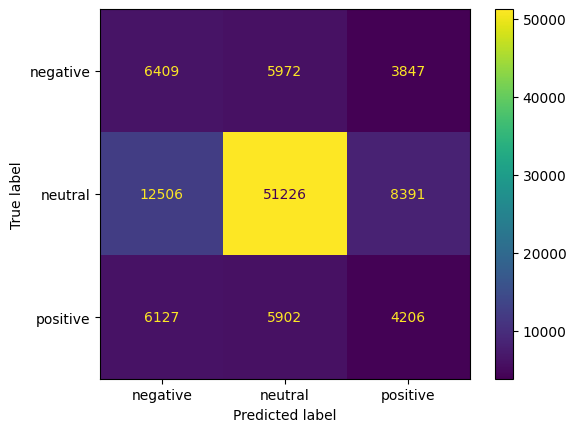

<Figure size 640x480 with 0 Axes>

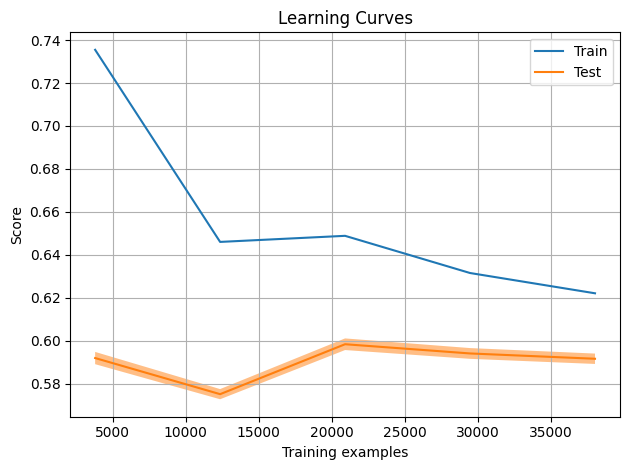

<Figure size 640x480 with 0 Axes>

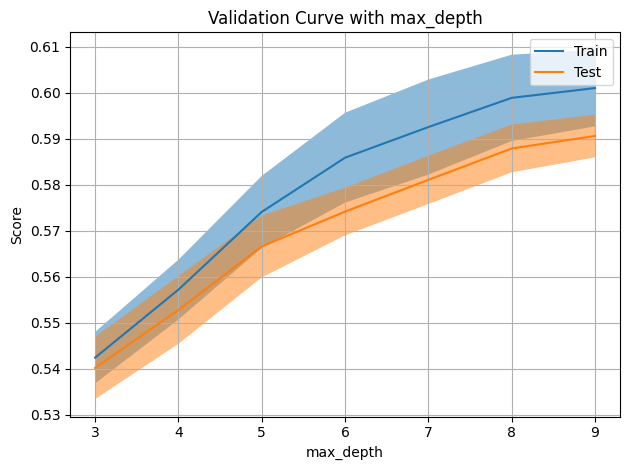

Best RFC model for BINANCE - orderbook
Parameters: {'classifier__criterion': 'gini', 'classifier__max_depth': 9, 'classifier__max_leaf_nodes': 50, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 4}
Best score: 0.5411140660230098
Confusion matrix:


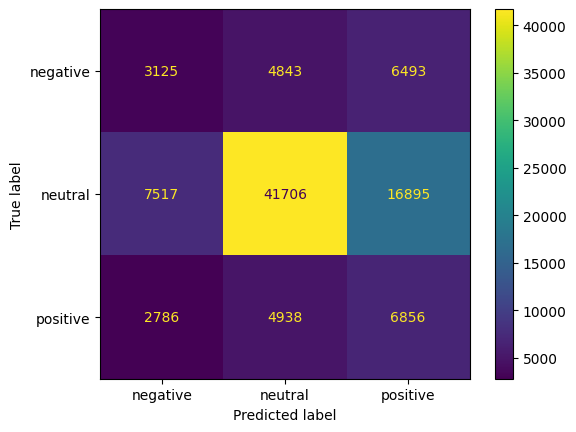

<Figure size 640x480 with 0 Axes>

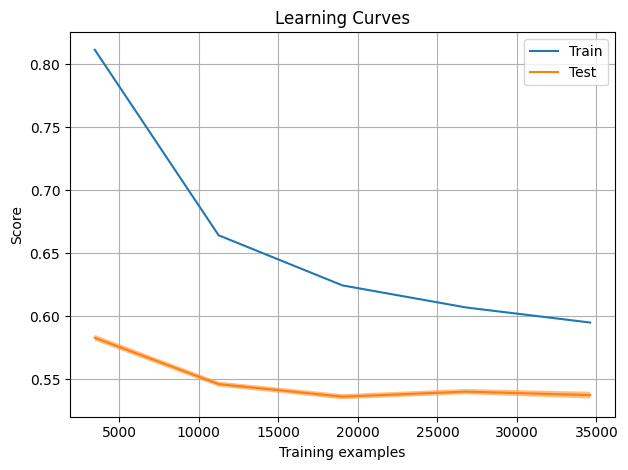

<Figure size 640x480 with 0 Axes>

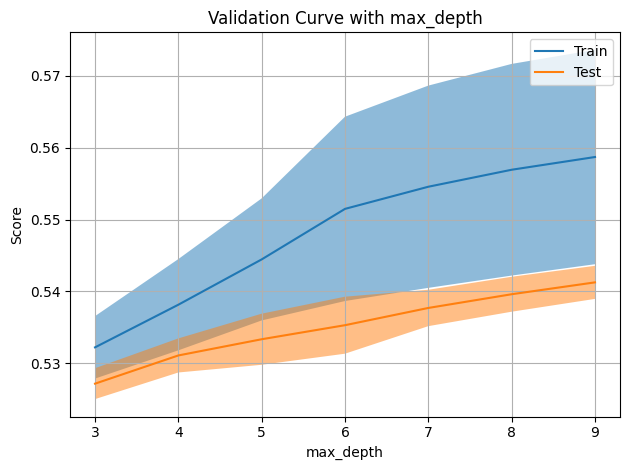

Best RFC model for BINANCE - unified
Parameters: {'classifier__criterion': 'entropy', 'classifier__max_depth': 8, 'classifier__max_leaf_nodes': 50, 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 9}
Best score: 0.574923397120888
Confusion matrix:


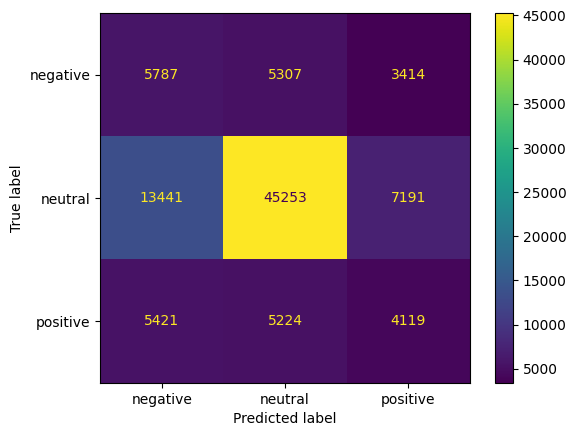

<Figure size 640x480 with 0 Axes>

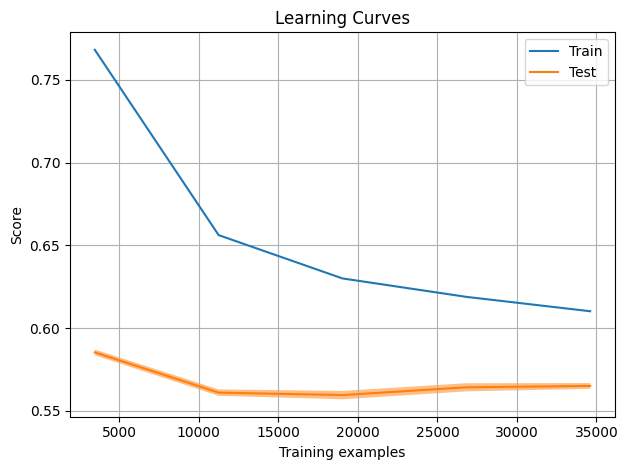

<Figure size 640x480 with 0 Axes>

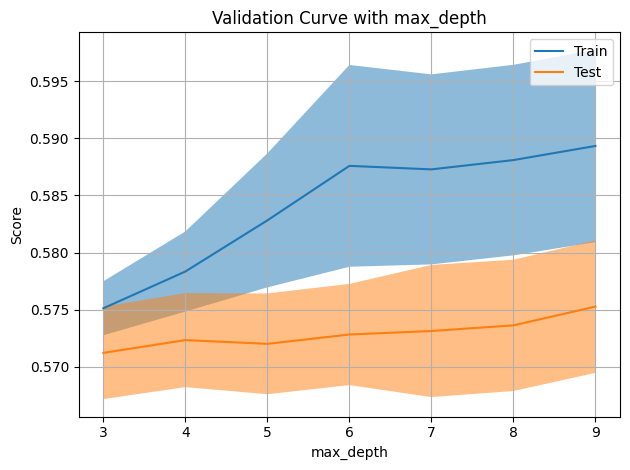

Best RFC model for HUOBI - candles
Parameters: {'classifier__criterion': 'entropy', 'classifier__max_depth': 9, 'classifier__max_leaf_nodes': 50, 'classifier__min_samples_leaf': 3, 'classifier__min_samples_split': 2}
Best score: 0.5614988131570022
Confusion matrix:


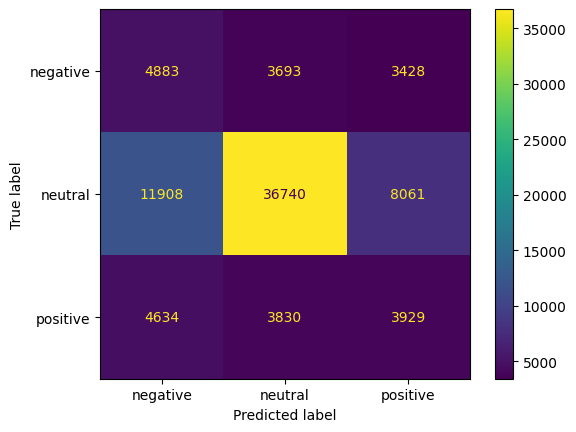

<Figure size 640x480 with 0 Axes>

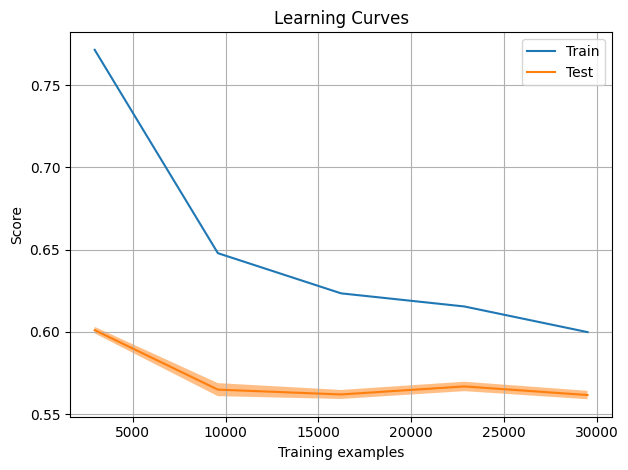

<Figure size 640x480 with 0 Axes>

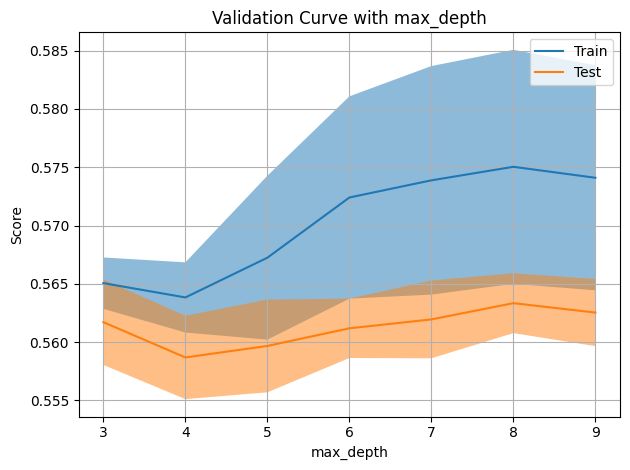

Best RFC model for HUOBI - orderbook
Parameters: {'classifier__criterion': 'gini', 'classifier__max_depth': 7, 'classifier__max_leaf_nodes': 50, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 4}
Best score: 0.5236629112945865
Confusion matrix:


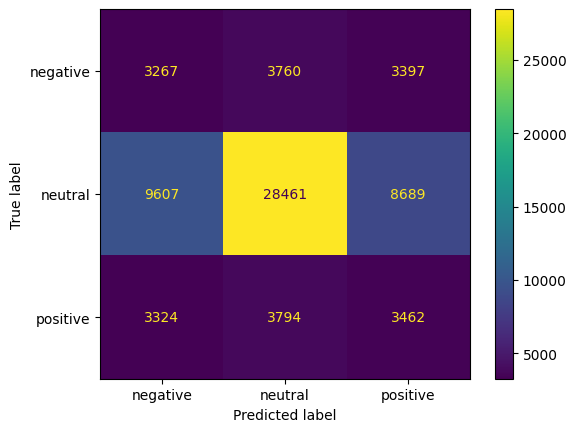

<Figure size 640x480 with 0 Axes>

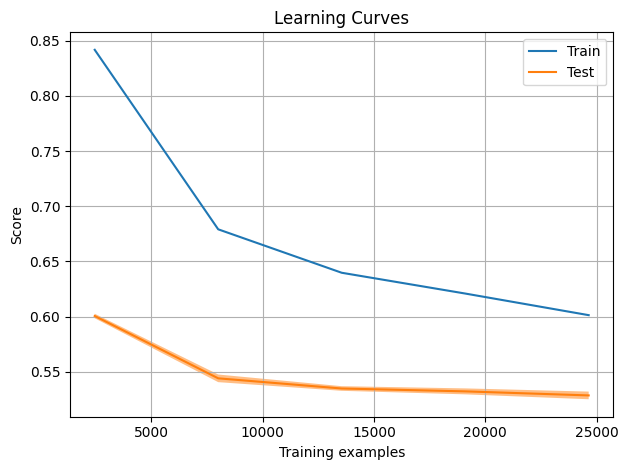

<Figure size 640x480 with 0 Axes>

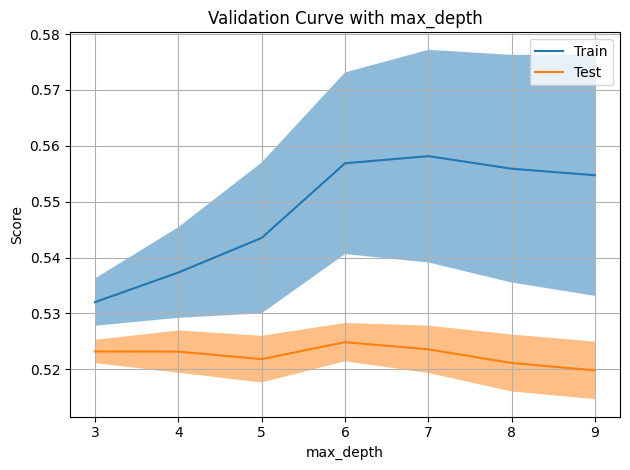

Best RFC model for HUOBI - unified
Parameters: {'classifier__criterion': 'entropy', 'classifier__max_depth': 8, 'classifier__max_leaf_nodes': 50, 'classifier__min_samples_leaf': 3, 'classifier__min_samples_split': 6}
Best score: 0.56419245942978
Confusion matrix:


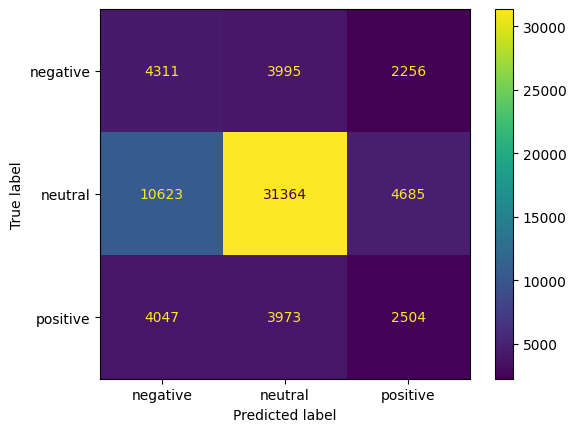

<Figure size 640x480 with 0 Axes>

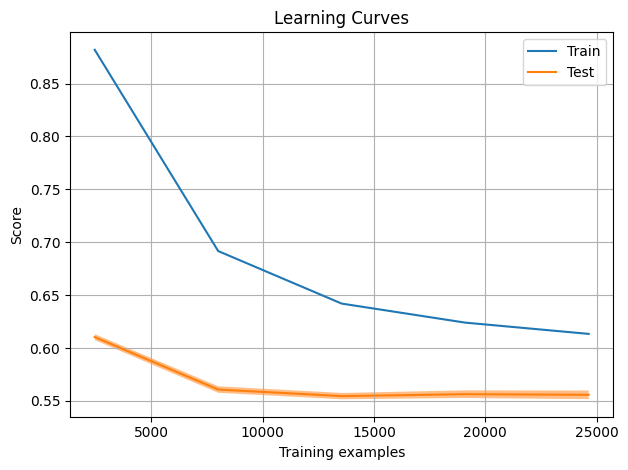

<Figure size 640x480 with 0 Axes>

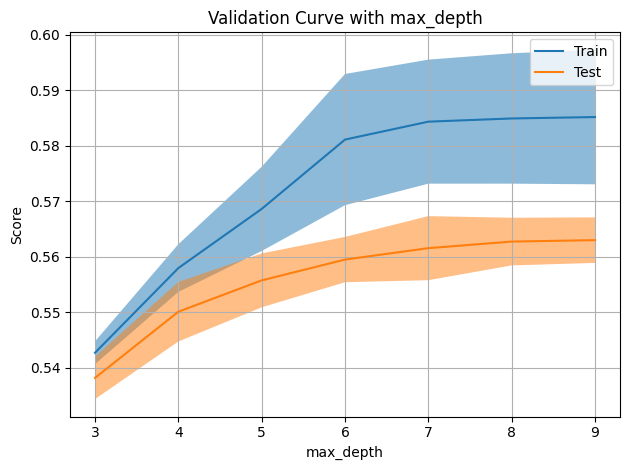

Best RFC model for OKX - candles
Parameters: {'classifier__criterion': 'entropy', 'classifier__max_depth': 8, 'classifier__max_leaf_nodes': 50, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 5}
Best score: 0.5667552285578037
Confusion matrix:


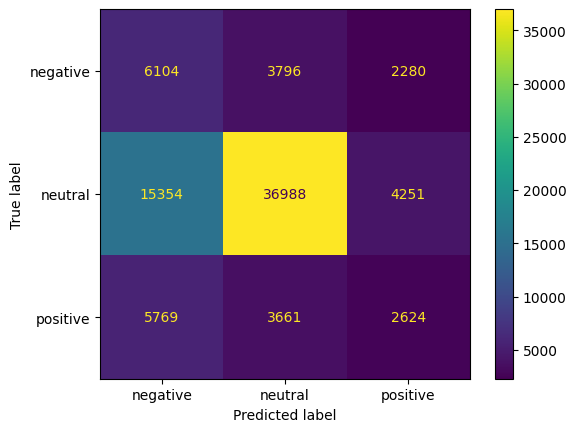

<Figure size 640x480 with 0 Axes>

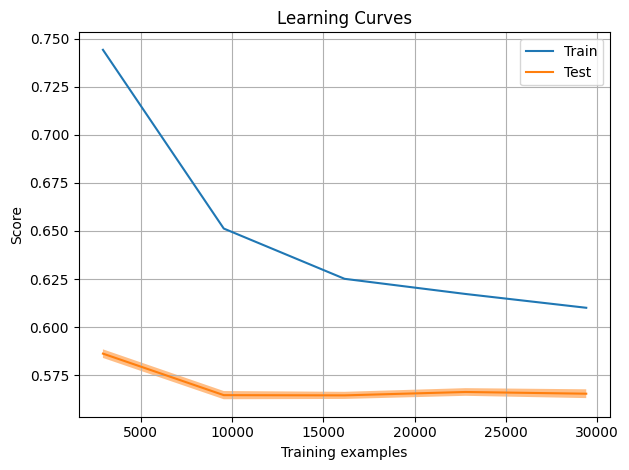

<Figure size 640x480 with 0 Axes>

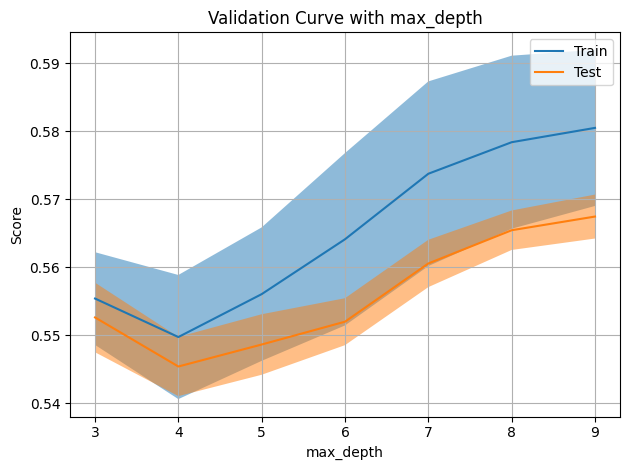

Best RFC model for OKX - orderbook
Parameters: {'classifier__criterion': 'gini', 'classifier__max_depth': 8, 'classifier__max_leaf_nodes': 50, 'classifier__min_samples_leaf': 3, 'classifier__min_samples_split': 3}
Best score: 0.5256843065693431
Confusion matrix:


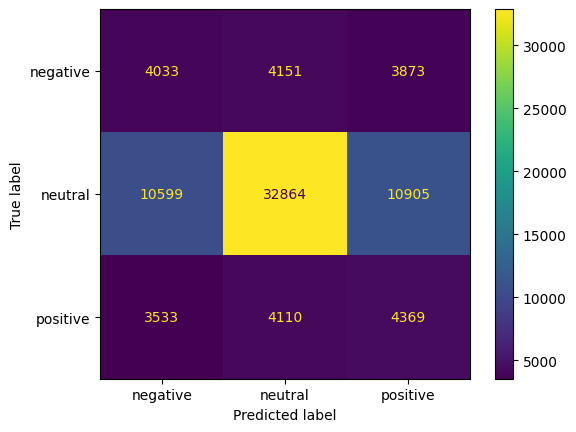

<Figure size 640x480 with 0 Axes>

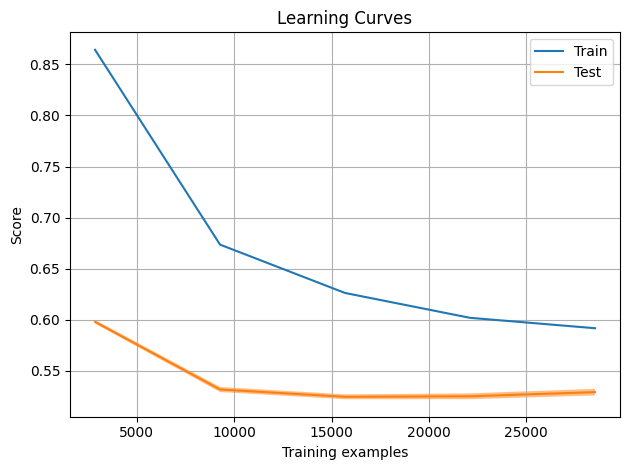

<Figure size 640x480 with 0 Axes>

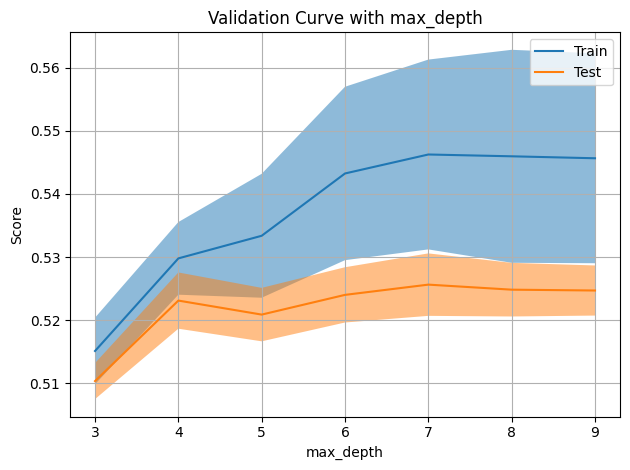

Best RFC model for OKX - unified
Parameters: {'classifier__criterion': 'entropy', 'classifier__max_depth': 9, 'classifier__max_leaf_nodes': 50, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 3}
Best score: 0.577446359479423
Confusion matrix:


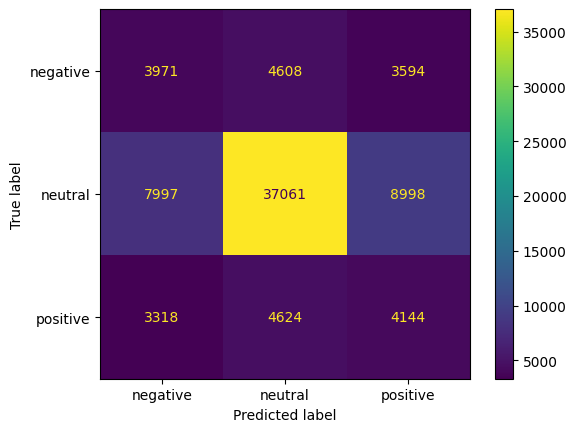

<Figure size 640x480 with 0 Axes>

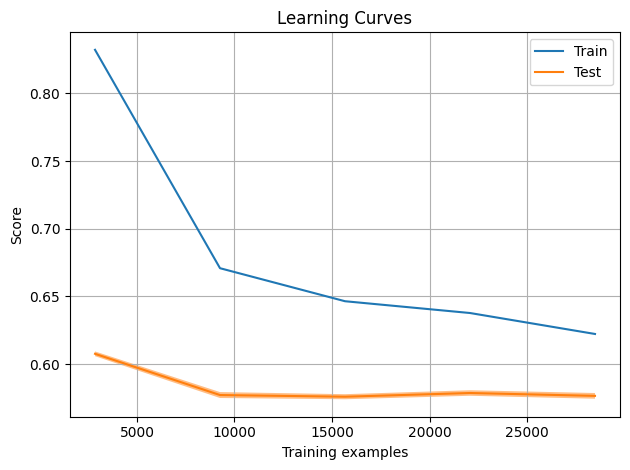

<Figure size 640x480 with 0 Axes>

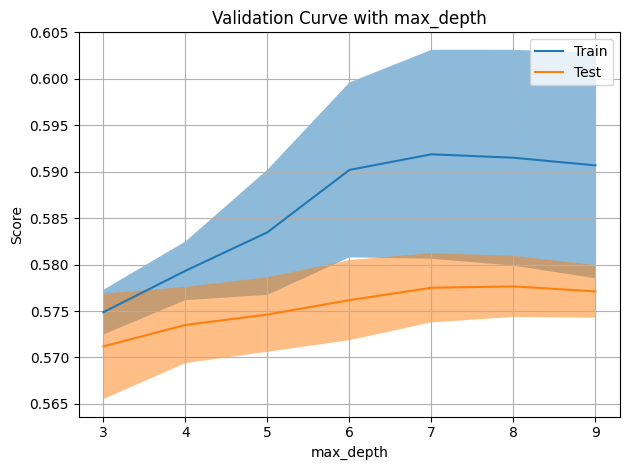

Best RFC model for ALL - unified
Parameters: {'classifier__criterion': 'gini', 'classifier__max_depth': 8, 'classifier__max_leaf_nodes': 50, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 4}
Best score: 0.5906835609136014
Confusion matrix:


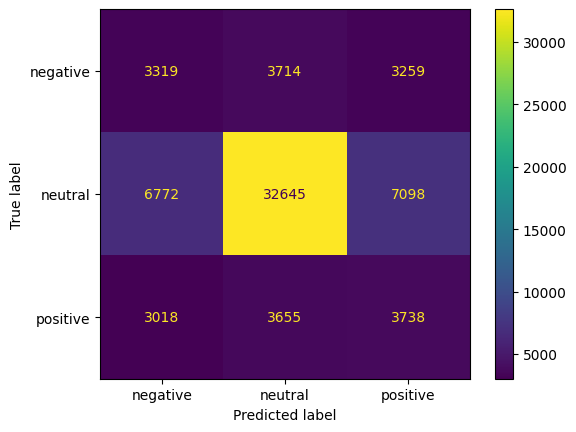

<Figure size 640x480 with 0 Axes>

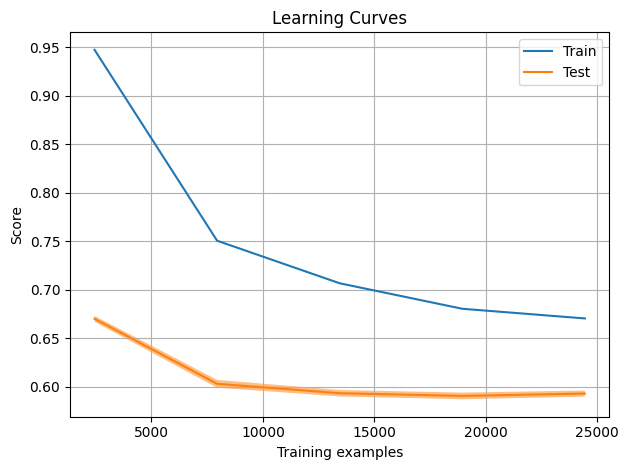

<Figure size 640x480 with 0 Axes>

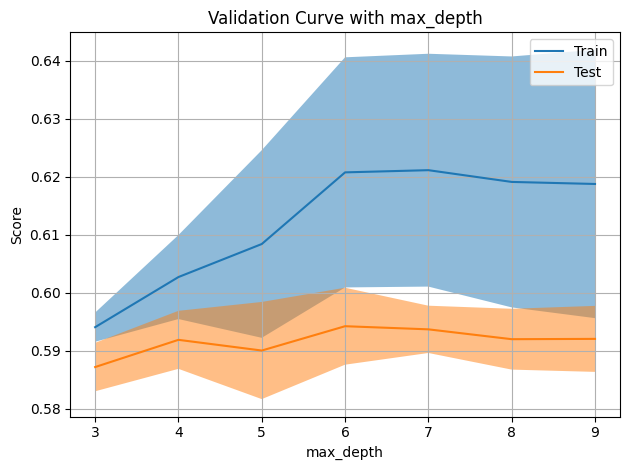

In [5]:
# Evaluation

eval_results = []
for (exchange, data_type), btcf in btcfs.items():
        print(f"Best RFC model for {exchange} - {data_type}")

        btcf.evaluate_model()

        print(f"Parameters: {btcf.results['best_params']}")
        print(f"Best score: {btcf.results['best_score']}")

        print(f"Confusion matrix:")
        plot_confusion_matrix(confusion_matrix=btcf.results['conf_matrix'], display_labels=list(btcf.le.classes_))

        # Plots
        if(btcf.rfe):
                btcf.plot_feature_importance(f"{exchange}_{data_type}_rfc_feature_importance.png")
        btcf.plot_learning_curves(f"{exchange}_{data_type}_rfc_learning_curve.png")
        btcf.plot_validation_curves('max_depth', view_params[data_type]['max_depth_range'], f"{exchange}_{data_type}_rfc_validation_curve_max_depth.png")

In [17]:
# Evaluation results

eval_results = []
for (exchange, data_type), model in btcfs.items():

    result = {
        'exchange': exchange,
        'data_type': data_type,
        'accuracy': model.results.get('accuracy'),
        'mean_test_score': model.results['cv_results']['mean_test_score'],
        'mean_fit_time': model.results['cv_results']['mean_fit_time'],
        'mean_score_time': model.results['cv_results']['mean_score_time'],
        'mean_train_score': model.results['cv_results']['mean_train_score']
    }
    best_params = model.results.get('best_params')
    result.update(best_params)
    eval_results.append(result)

eval_results_df = pd.DataFrame(eval_results)
display(eval_results_df)


,exchange,data_type,accuracy,mean_test_score,mean_fit_time,mean_score_time,mean_train_score,classifier__criterion,classifier__max_depth,classifier__max_leaf_nodes,classifier__min_samples_leaf,classifier__min_samples_split
0,BINANCE,candles,0.591293,"[0.5826923076923077, 0.5846153846153846, 0.588...","[0.19828684329986573, 0.19223554134368898, 0.1...","[0.006100964546203613, 0.007201194763183594, 0...","[0.805424297924298, 0.8053441697191698, 0.8032...",entropy,9,50,4,2
1,BINANCE,orderbook,0.543165,"[0.5765957446808511, 0.5765957446808511, 0.578...","[0.2122891902923584, 0.20733842849731446, 0.21...","[0.006051301956176758, 0.006001114845275879, 0...","[0.882348687932919, 0.8824685824933344, 0.8818...",gini,9,50,2,4
2,BINANCE,unified,0.579663,"[0.6063829787234042, 0.6042553191489362, 0.595...","[0.22474162578582763, 0.22434136867523194, 0.2...","[0.006501102447509765, 0.006751298904418945, 0...","[0.8927407471455526, 0.8901537940662813, 0.892...",entropy,8,50,4,9
3,HUOBI,candles,0.561635,"[0.6100000000000001, 0.6075, 0.6125, 0.6075, 0...","[0.18398408889770507, 0.18853480815887452, 0.1...","[0.006201004981994629, 0.00600123405456543, 0....","[0.8618395526459454, 0.8627258651769736, 0.860...",entropy,9,50,3,2
4,HUOBI,orderbook,0.519325,"[0.6272727272727274, 0.6242424242424244, 0.633...","[0.19053537845611573, 0.19708645343780518, 0.1...","[0.005601072311401367, 0.0057010650634765625, ...","[0.9462394008403724, 0.9467344503453228, 0.943...",gini,7,50,2,4
5,HUOBI,unified,0.563461,"[0.5848484848484847, 0.5818181818181818, 0.578...","[0.19123542308807373, 0.1930356502532959, 0.19...","[0.006151032447814941, 0.005801177024841309, 0...","[0.944857700803394, 0.9442624627081558, 0.9440...",entropy,8,50,3,6
6,OKX,candles,0.565603,"[0.615, 0.6225, 0.6225, 0.6225, 0.615, 0.62500...","[0.1787328004837036, 0.17428245544433593, 0.17...","[0.006101226806640625, 0.006100988388061524, 0...","[0.8504202508907982, 0.8508974875158154, 0.848...",entropy,8,50,1,5
7,OKX,orderbook,0.526104,"[0.5923076923076923, 0.5923076923076923, 0.597...","[0.20598788261413575, 0.20813841819763185, 0.1...","[0.005700945854187012, 0.005801153182983398, 0...","[0.9393711843711845, 0.9393711843711845, 0.940...",gini,8,50,3,3
8,OKX,unified,0.576850,"[0.6078947368421053, 0.6105263157894737, 0.605...","[0.21235370635986328, 0.20885281562805175, 0.2...","[0.006301712989807129, 0.0058515071868896484, ...","[0.9400081400081401, 0.9391819291819292, 0.937...",entropy,9,50,1,3
9,ALL,unified,0.590645,"[0.6454545454545456, 0.6424242424242425, 0.642...","[0.23070826530456542, 0.23961074352264405, 0.2...","[0.006851887702941895, 0.006951737403869629, 0...","[0.9901413481658633, 0.9912729752770894, 0.990...",gini,8,50,2,4


In [15]:
# Performing t-tests for each metric

metrics = ['mean_test_score', 'mean_fit_time', 'mean_score_time', 'mean_train_score']
ttest_results = pd.concat([perform_ttest(eval_results_df, metric) for metric in metrics], ignore_index=True)

display(ttest_results)

,data_type,exchange1,exchange2,metric,t_stat,p_value
0,candles,BINANCE,HUOBI,mean_test_score,-23.256628,2.081920e-111
1,candles,BINANCE,OKX,mean_test_score,-40.640965,3.846803e-302
2,candles,HUOBI,OKX,mean_test_score,-10.552929,1.118718e-25
3,orderbook,BINANCE,HUOBI,mean_test_score,-42.203435,1.086944e-322
4,orderbook,BINANCE,OKX,mean_test_score,-26.839778,7.311577e-146
5,orderbook,HUOBI,OKX,mean_test_score,18.607741,3.907765e-74
6,unified,BINANCE,HUOBI,mean_test_score,15.803498,1.355703e-54
7,unified,BINANCE,OKX,mean_test_score,-1.896564,5.795959e-02
8,unified,BINANCE,ALL,mean_test_score,-20.993473,7.968224e-91
9,unified,HUOBI,OKX,mean_test_score,-19.604226,8.329137e-82


In [9]:
# Results comparison

data_types = eval_results_df['data_type'].unique()
all_comparisons = pd.concat([compute_comparison(eval_results_df, data_type) for data_type in data_types], ignore_index=True)

display(all_comparisons)

,data_type,exchange1,exchange2,exchange1_mean_lower,exchange1_mean_upper,exchange2_mean_lower,exchange2_mean_upper,mean_diff_lower,mean_diff_upper,exchange1_ci_percentage,exchange2_ci_percentage,mean_diff_ci_percentage
0,candles,BINANCE,HUOBI,0.607031,0.608908,0.627551,0.630552,-0.022776,-0.019299,0.309158,0.478177,15.268897
1,candles,BINANCE,OKX,0.607084,0.609034,0.637833,0.640080,-0.032352,-0.029468,0.321132,0.352306,8.912598
2,candles,HUOBI,OKX,0.627608,0.630568,0.637854,0.640041,-0.011656,-0.008044,0.471751,0.342842,30.991014
3,orderbook,BINANCE,HUOBI,0.604504,0.607617,0.653304,0.656497,-0.051211,-0.046591,0.514919,0.488728,9.020396
4,orderbook,BINANCE,OKX,0.604578,0.607809,0.633498,0.636298,-0.030881,-0.026668,0.534371,0.442084,13.642583
5,orderbook,HUOBI,OKX,0.653336,0.656583,0.633573,0.636343,0.017807,0.022154,0.496950,0.437216,24.417008
6,unified,BINANCE,HUOBI,0.641594,0.644546,0.625149,0.627732,0.014552,0.018590,0.459967,0.413146,27.750830
7,unified,BINANCE,OKX,0.641351,0.644617,0.643647,0.646252,-0.003980,0.000119,0.509306,0.404746,102.978787
8,unified,BINANCE,ALL,0.641437,0.644569,0.660456,0.661748,-0.019753,-0.016412,0.488278,0.195717,16.910106
9,unified,HUOBI,OKX,0.625178,0.627821,0.643629,0.646216,-0.020255,-0.016671,0.422694,0.401923,17.695235


### General Insights
BINANCE models generally outperform those from HUOBI and OKX, with significant differences in most metrics, suggesting better market conditions for BINANCE. Thus, the focus should be on leveraging BINANCE data for more accurate predictions, as it consistently shows better performance. Improving data pipelines for HUOBI and OKX could also help boost their predictive capabilities. 

The t-tests on train and test scores indicate that some models, especially from HUOBI, may be underfitting, as seen in lower training and testing scores. Conversely, significant differences between train and test scores for BINANCE models suggest potential overfitting, necessitating more robust validation techniques.

Underfitting should be addressed by improving feature engineering for HUOBI and OKX datasets, and mitigate overfitting in BINANCE models through better cross-validation and regularization.